In [28]:
from typing import List
import numpy as np
import xarray as xr
from pathlib import Path
from winter_year import WinterYear


winter_year = WinterYear(2023, 2024)
time_series_folder = '../output_folder/version_3'

s2_filename = 'WY_2023_2024_S2_res_1000m.nc'
mf_filename = 'WY_2023_2024_SNPP_meteofrance_res_1000m.nc'
nasa_l3_filename = 'WY_2023_2024_SNPP_nasa_l3_res_1000m.nc'
nasa_pseudo_l3_filename = 'WY_2023_2024_SNPP_nasa_pseudo_l3_res_1000m.nc'
s2_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(s2_filename))
meteofrance_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(mf_filename))
nasa_l3_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(nasa_l3_filename))
nasa_pseudo_l3_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(nasa_pseudo_l3_filename))


def find_common_days(time_series_list: List[xr.Dataset]):
    common_days_old = time_series_list[0]["time"]
    for i in range(1,len(time_series_list)):
        common_days_new= np.intersect1d(common_days_old, time_series_list[i]["time"])
        common_days_old = common_days_new
    return common_days_new

common_days = find_common_days(time_series_list=[s2_time_series, meteofrance_time_series, nasa_l3_time_series, nasa_pseudo_l3_time_series])
s2_time_series = s2_time_series.sel(time=common_days)
meteofrance_time_series = meteofrance_time_series.sel(time=common_days)
nasa_l3_time_series = nasa_l3_time_series.sel(time=common_days)
nasa_pseudo_l3_time_series = nasa_pseudo_l3_time_series.sel(time=common_days)
products_to_compare = {'Météo-France': meteofrance_time_series, 'NASA L3': nasa_l3_time_series, 'NASA pseudo L3': nasa_pseudo_l3_time_series}

In [18]:
from typing import List
from datetime import datetime


def daily_average(data_array: xr.DataArray):
    time_coord = data_array.coords['time'].values
    month_datetime = datetime(int(str(time_coord[0])[:4]), int(str(time_coord[0])[5:7]), int(str(time_coord[0])[8:10]))
    return xr.DataArray([data_array.sum().values / len(time_coord)], coords={'time': [month_datetime]})

def difference_array_to_bias_rmse(difference_array: np.array):
    biais = np.nanmean(difference_array)
    rmse = np.sqrt(np.nanmean((difference_array- biais)**2))
    return biais, rmse

In [26]:
from typing import Dict

from products.classes import METEOFRANCE_CLASSES, NASA_CLASSES, S2_CLASSES
import pandas as pd
from datetime import datetime

valid_ranges_dict = {'Sentinel-2': {'fsc_max': S2_CLASSES['snow_cover'][-1]},
                     'Météo-France': {'fsc_max': METEOFRANCE_CLASSES['snow_cover'][-1]},
                     'NASA L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]},
                     'NASA pseudo L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]}}


def compute_monthly_bias_rmse_fsc(ref_time_series: Dict[str, xr.Dataset], time_series_to_compare: Dict[str, xr.Dataset], fsc_threshold: float = 0):

    months = pd.date_range("2023-10-01",periods=12,freq="ME")
    months = [datetime(year=month.year, month=month.month, day=1) for month in months]
    errors = xr.Dataset({'biais': xr.DataArray(np.nan, dims=('time', 'product', 'ref_fsc'),coords={'time':months, 'product': list(products_to_compare.keys()), 'ref_fsc': ['0', '1-99','1-100', 'all']}),
                    'unbiased_RMSD': xr.DataArray(np.nan, dims=('time', 'product', 'ref_fsc'),coords={'time':months, 'product': list(products_to_compare.keys()), 'ref_fsc': ['0', '1-99','1-100', 'all']})})

    for month in months:
        print("Processing month no.", month.strftime("%Y-%m"))
        ref_snow_cover = list(ref_time_series.values())[0].data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m"))
        ref_fsc_max = valid_ranges_dict[list(ref_time_series.keys())[0]]['fsc_max']
        ref_mask = ref_snow_cover  <= ref_fsc_max 
        ref_snow_cover = ref_snow_cover.where(ref_mask) / ref_fsc_max
        for product_name, product in time_series_to_compare.items():
            print("Processing product", product_name)
            product_snow_cover = product.data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m")) 
            if fsc_threshold>0:
                product_snow_cover.where(product_snow_cover  >= fsc_threshold, 0)

            product_fscmax = valid_ranges_dict[product_name]['fsc_max']
            product_mask = (product_snow_cover  < product_fscmax) 
            product_snow_cover = product_snow_cover.where(product_mask) / product_fscmax

            difference = product_snow_cover - ref_snow_cover
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, 'all'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, 'all'] = rmse
            print('all',biais*100, rmse*100)
            difference = product_snow_cover.where(ref_snow_cover==0) - ref_snow_cover.where(ref_snow_cover==0)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '0'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '0']= rmse
            print('0',biais*100, rmse*100)
            difference = product_snow_cover.where(ref_snow_cover>0) - ref_snow_cover.where(ref_snow_cover>0)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '1-100']  = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '1-100'] = rmse
            print('1-100',biais*100, rmse*100)
            difference = product_snow_cover.where(ref_snow_cover>0).where(ref_snow_cover < ref_fsc_max) - ref_snow_cover.where(ref_snow_cover>0).where(ref_snow_cover < ref_fsc_max)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '1-99'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '1-99'] = rmse
            print('1-99',biais*100, rmse*100)
    return errors

errors_fsc = compute_monthly_bias_rmse_fsc(ref_time_series={"Sentinel-2": s2_time_series}, time_series_to_compare=products_to_compare, fsc_threshold=15)
errors_fsc.to_netcdf(f'{time_series_folder}/WY_2023_2024_SNPP_res_1000m_errors_fsc.nc')

Processing month no. 2023-10
Processing product Météo-France
all -0.01882661 0.88779676
0 0.004434447 0.24043894
1-100 -6.441807 12.6909
1-99 -6.441807 12.6909
Processing product NASA pseudo L3
all 0.00488036 0.927345
0 0.017058637 0.46418667
1-100 -3.7690904 13.649088
1-99 -3.7690904 13.649088
Processing month no. 2023-11
Processing product Météo-France
all 1.3069484 8.970759
0 0.116853915 2.137263
1-100 9.601985 23.040598
1-99 9.601985 23.040598
Processing product NASA pseudo L3
all 0.9339475 5.71615
0 0.41157612 2.8891087
1-100 9.179315 18.557413
1-99 9.179315 18.557413
Processing month no. 2023-12
Processing product Météo-France
all 1.4524039 9.280877
0 0.15574595 2.488181
1-100 9.384186 22.404459
1-99 9.384186 22.404459
Processing product NASA pseudo L3
all 1.8990259 8.487578
0 0.72207147 3.5042405
1-100 9.195651 19.51135
1-99 9.195651 19.51135
Processing month no. 2024-01
Processing product Météo-France
all 0.31485516 12.258647
0 0.09849564 1.8785065
1-100 1.017539 25.024467
1-99

In [20]:
from typing import Dict

from products.classes import METEOFRANCE_CLASSES, NASA_CLASSES, S2_CLASSES
import pandas as pd
from datetime import datetime

valid_ranges_dict = {'Sentinel-2': {'fsc_max': S2_CLASSES['snow_cover'][-1]},
                     'Météo-France': {'fsc_max': METEOFRANCE_CLASSES['snow_cover'][-1]},
                     'NASA L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]},
                     'NASA pseudo L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]}}


def compute_monthly_bias_rmse_fsc(ref_time_series: Dict[str, xr.Dataset], time_series_to_compare: Dict[str, xr.Dataset], fsc_threshold: float = 0):

    months = pd.date_range("2023-10-01",periods=12,freq="ME")
    months = [datetime(year=month.year, month=month.month, day=1) for month in months]
    errors = xr.Dataset({'biais': xr.DataArray(np.nan, dims=('time', 'product', 'sensor_zenith'),coords={'time':months, 'product': list(products_to_compare.keys()), 'sensor_zenith': ['0-15', '15-30','30-45','45-60','>60', 'all']}),
                    'unbiased_RMSD': xr.DataArray(np.nan, dims=('time', 'product', 'sensor_zenith'),coords={'time':months, 'product': list(products_to_compare.keys()), 'sensor_zenith': ['0-15', '15-30','30-45','45-60','>60', 'all']})})

    for month in months:
        print("Processing month no.", month.strftime("%Y-%m"))
        ref_snow_cover = list(ref_time_series.values())[0].data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m"))
        ref_fsc_max = valid_ranges_dict[list(ref_time_series.keys())[0]]['fsc_max']
        ref_mask = ref_snow_cover  <= ref_fsc_max 
        ref_snow_cover = ref_snow_cover.where(ref_mask) / ref_fsc_max
        for product_name, product in time_series_to_compare.items():
            print("Processing product", product_name)
            product_snow_cover = product.data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m")) 
            product_vza = product.data_vars['sensor_zenith'].sel(time=month.strftime("%Y-%m")) 
            if fsc_threshold>0:
                product_snow_cover.where(product_snow_cover  >= fsc_threshold, 0)

            product_fscmax = valid_ranges_dict[product_name]['fsc_max']
            product_mask = (product_snow_cover  < product_fscmax) 
            product_snow_cover = product_snow_cover.where(product_mask) / product_fscmax
            product_vza = product_vza.where(product_mask)

            difference = product_snow_cover - ref_snow_cover
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, 'all'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, 'all'] = rmse
            print('all',biais*100, rmse*100)
            mask_inf = product_vza >=0
            mask_sup = product_vza <15
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '0-15'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '0-15']= rmse
            print('0-15',biais*100, rmse*100)
            mask_inf = product_vza >=15
            mask_sup = product_vza <30
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '15-30'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '15-30']= rmse
            print('15-30',biais*100, rmse*100)
            mask_inf = product_vza >=30
            mask_sup = product_vza <45
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '30-45'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '30-45']= rmse
            print('30-45',biais*100, rmse*100)
            mask_inf = product_vza >=45
            mask_sup = product_vza <60
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '45-60'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '45-60']= rmse
            print('45-60',biais*100, rmse*100)
            mask_inf = product_vza >=60
            difference = product_snow_cover.where(mask_inf) - ref_snow_cover.where(mask_inf)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '>60'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '>60']= rmse
            print('>60',biais*100, rmse*100)
    return errors
products_to_compare = {'Météo-France': meteofrance_time_series, 'NASA pseudo L3': nasa_pseudo_l3_time_series}
errors_vza = compute_monthly_bias_rmse_fsc(ref_time_series={"Sentinel-2": s2_time_series}, time_series_to_compare=products_to_compare, fsc_threshold=0)
errors_vza.to_netcdf(f'{time_series_folder}/WY_2023_2024_SNPP_res_1000m_errors_vza.nc')

Processing month no. 2023-10
Processing product Météo-France
all -0.01882661 0.88779676
0-15 0.0 0.0
15-30 -0.005254468 0.5013658
30-45 -0.019176776 0.6909476
45-60 -0.01847881 0.93411875
>60 -0.11031719 2.4607816
Processing product NASA pseudo L3
all 0.00488036 0.927345
0-15 0.0100124115 0.38687485
15-30 -0.006326814 0.3238891
30-45 -0.0009985309 0.7275147
45-60 0.024379553 1.5267941
>60 0.190136 3.9000583
Processing month no. 2023-11
Processing product Météo-France
all 1.3069484 8.970759
0-15 0.22671156 2.9717886
15-30 1.3117363 7.194128
30-45 1.1502022 7.7740474
45-60 2.0467267 11.9427185
>60 2.1607275 14.33434
Processing product NASA pseudo L3
all 0.9339475 5.71615
0-15 0.0483672 1.2963682
15-30 0.20732942 2.9831998
30-45 0.66043556 4.9201193
45-60 2.0488043 8.492807
>60 7.096361 12.893589
Processing month no. 2023-12
Processing product Météo-France
all 1.4524039 9.280877
0-15 2.5107841 9.487846
15-30 0.79572546 5.7722836
30-45 1.792973 10.029308
45-60 1.2588935 8.735873
>60 0.9567

In [22]:
from typing import Dict

from products.classes import METEOFRANCE_CLASSES, NASA_CLASSES, S2_CLASSES
import pandas as pd
from datetime import datetime

valid_ranges_dict = {'Sentinel-2': {'fsc_max': S2_CLASSES['snow_cover'][-1]},
                     'Météo-France': {'fsc_max': METEOFRANCE_CLASSES['snow_cover'][-1]},
                     'NASA L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]},
                     'NASA pseudo L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]}}


def compute_monthly_bias_rmse_fsc(ref_time_series: Dict[str, xr.Dataset], time_series_to_compare: Dict[str, xr.Dataset], fsc_threshold: float = 0):

    months = pd.date_range("2023-10-01",periods=12,freq="ME")
    months = [datetime(year=month.year, month=month.month, day=1) for month in months]
    errors = xr.Dataset({'biais': xr.DataArray(np.nan, dims=('time', 'product', 'sensor_zenith'),coords={'time':months, 'product': list(products_to_compare.keys()), 'sensor_zenith': ['0-15', '15-30','30-45','45-60','>60', 'all']}),
                    'unbiased_RMSD': xr.DataArray(np.nan, dims=('time', 'product', 'sensor_zenith'),coords={'time':months, 'product': list(products_to_compare.keys()), 'sensor_zenith': ['0-15', '15-30','30-45','45-60','>60', 'all']})})

    for month in months:
        print("Processing month no.", month.strftime("%Y-%m"))
        ref_snow_cover = list(ref_time_series.values())[0].data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m"))
        ref_fsc_max = valid_ranges_dict[list(ref_time_series.keys())[0]]['fsc_max']
        ref_mask_sup = ref_snow_cover  <= ref_fsc_max 
        ref_mask_inf = ref_snow_cover>0
        ref_snow_cover = ref_snow_cover.where(ref_mask_sup).where(ref_mask_inf) / ref_fsc_max
        for product_name, product in time_series_to_compare.items():
            print("Processing product", product_name)
            product_snow_cover = product.data_vars['snow_cover_fraction'].sel(time=month.strftime("%Y-%m")) 
            product_vza = product.data_vars['sensor_zenith'].sel(time=month.strftime("%Y-%m")) 
            if fsc_threshold>0:
                product_snow_cover.where(product_snow_cover  >= fsc_threshold, 0)

            product_fscmax = valid_ranges_dict[product_name]['fsc_max']
            product_mask = (product_snow_cover  < product_fscmax) 
            product_snow_cover = product_snow_cover.where(product_mask)/ product_fscmax
            product_vza = product_vza.where(product_mask)

            difference = product_snow_cover - ref_snow_cover
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, 'all'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, 'all'] = rmse
            print('all',biais*100, rmse*100)
            mask_inf = product_vza >=0
            mask_sup = product_vza <15
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '0-15'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '0-15']= rmse
            print('0-15',biais*100, rmse*100)
            mask_inf = product_vza >=15
            mask_sup = product_vza <30
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '15-30'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '15-30']= rmse
            print('15-30',biais*100, rmse*100)
            mask_inf = product_vza >=30
            mask_sup = product_vza <45
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '30-45'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '30-45']= rmse
            print('30-45',biais*100, rmse*100)
            mask_inf = product_vza >=45
            mask_sup = product_vza <60
            difference = product_snow_cover.where(mask_inf).where(mask_sup) - ref_snow_cover.where(mask_inf).where(mask_sup)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '45-60'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '45-60']= rmse
            print('45-60',biais*100, rmse*100)
            mask_inf = product_vza >=60
            difference = product_snow_cover.where(mask_inf) - ref_snow_cover.where(mask_inf)
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais'].loc[month,product_name, '>60'] = biais
            errors.data_vars['unbiased_RMSD'].loc[month,product_name, '>60']= rmse
            print('>60',biais*100, rmse*100)
    return errors
products_to_compare = {'Météo-France': meteofrance_time_series, 'NASA pseudo L3': nasa_pseudo_l3_time_series}
errors_vza_positive_fsc = compute_monthly_bias_rmse_fsc(ref_time_series={"Sentinel-2": s2_time_series}, time_series_to_compare=products_to_compare, fsc_threshold=0)
errors_vza_positive_fsc.to_netcdf(f'{time_series_folder}/WY_2023_2024_SNPP_res_1000m_errors_vza_positive_fsc.nc')

Processing month no. 2023-10
Processing product Météo-France
all -6.441807 12.6909


/tmp/ipykernel_37306/4225676704.py:16: RuntimeWarning: Mean of empty slice
  biais = np.nanmean(difference_array)
/tmp/ipykernel_37306/4225676704.py:17: RuntimeWarning: Mean of empty slice
  rmse = np.sqrt(np.nanmean((difference_array- biais)**2))


0-15 nan nan
15-30 -3.5434783 8.897255
30-45 -5.058642 7.8568177
45-60 -8.039326 15.948518
>60 -11.81746 19.20799
Processing product NASA pseudo L3
all -3.7690904 13.649088
0-15 nan nan
15-30 -3.579114 5.129655
30-45 -2.6796117 8.518186
45-60 -5.4366817 22.265402
>60 -9.75 32.797676
Processing month no. 2023-11
Processing product Météo-France
all 9.601985 23.040598
0-15 18.417809 20.938759
15-30 12.400455 19.149359
30-45 9.742249 20.891602
45-60 8.992604 24.13261
>60 8.307571 28.192696
Processing product NASA pseudo L3
all 9.179315 18.557413
0-15 6.133331 15.34999
15-30 2.8265562 13.23665
30-45 7.3142147 16.702137
45-60 12.236644 20.743324
>60 17.259598 19.986885
Processing month no. 2023-12
Processing product Météo-France
all 9.384186 22.404459
0-15 14.870371 18.834993
15-30 9.415169 17.883324
30-45 9.3429 21.628227
45-60 10.106702 23.407562
>60 2.8965266 24.982124
Processing product NASA pseudo L3
all 9.195651 19.51135
0-15 15.20887 20.64034
15-30 2.4899435 14.821394
30-45 5.5454874 

/tmp/ipykernel_37306/4225676704.py:16: RuntimeWarning: Mean of empty slice
  biais = np.nanmean(difference_array)
/tmp/ipykernel_37306/4225676704.py:17: RuntimeWarning: Mean of empty slice
  rmse = np.sqrt(np.nanmean((difference_array- biais)**2))


0-15 nan nan
15-30 nan nan
30-45 -10.999998 0.99999905
45-60 -1.1228287 15.079949
>60 -4.8888893 5.1303988
Processing product NASA pseudo L3
all -1.3592871 10.227221
0-15 nan nan
15-30 0.0 0.0
30-45 1.5133992e-07 8.031189
45-60 -1.404031 10.245775
>60 1.9999995 11.771636


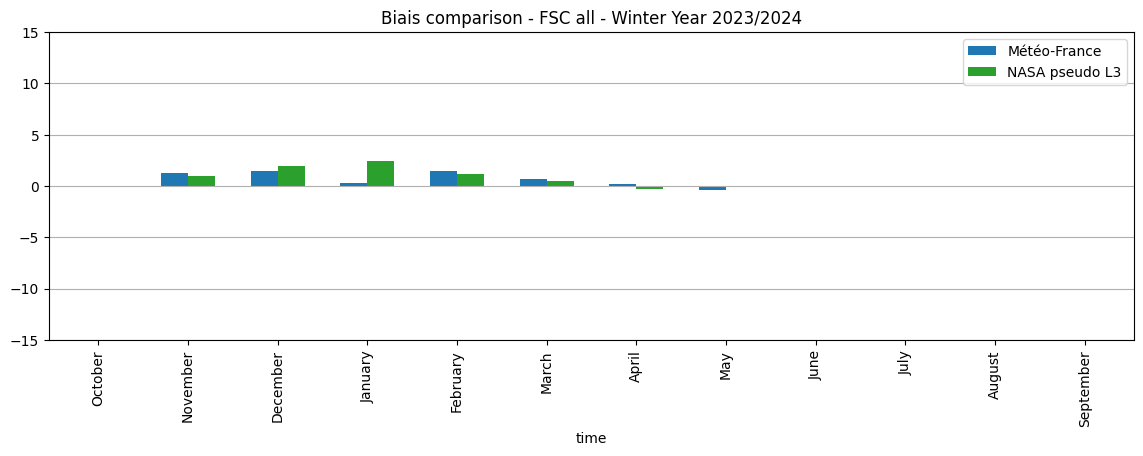

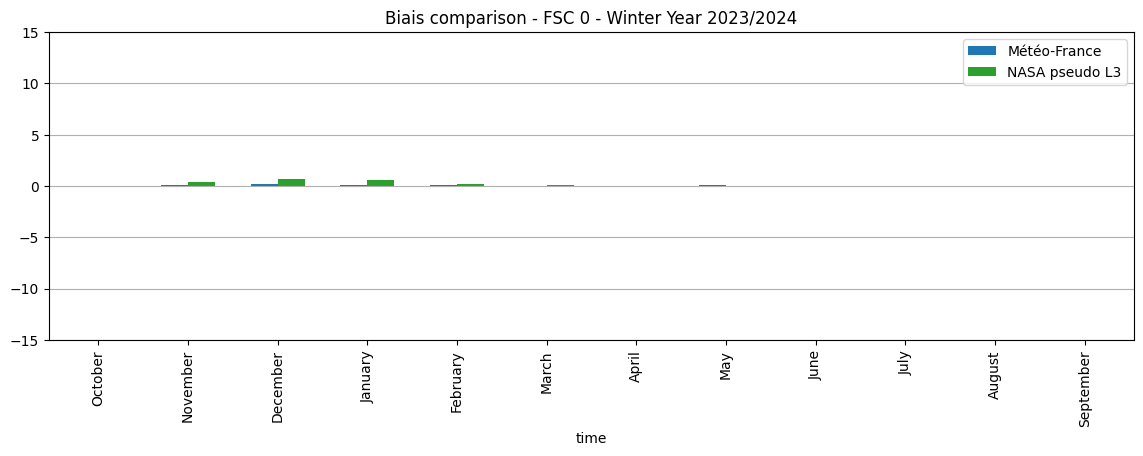

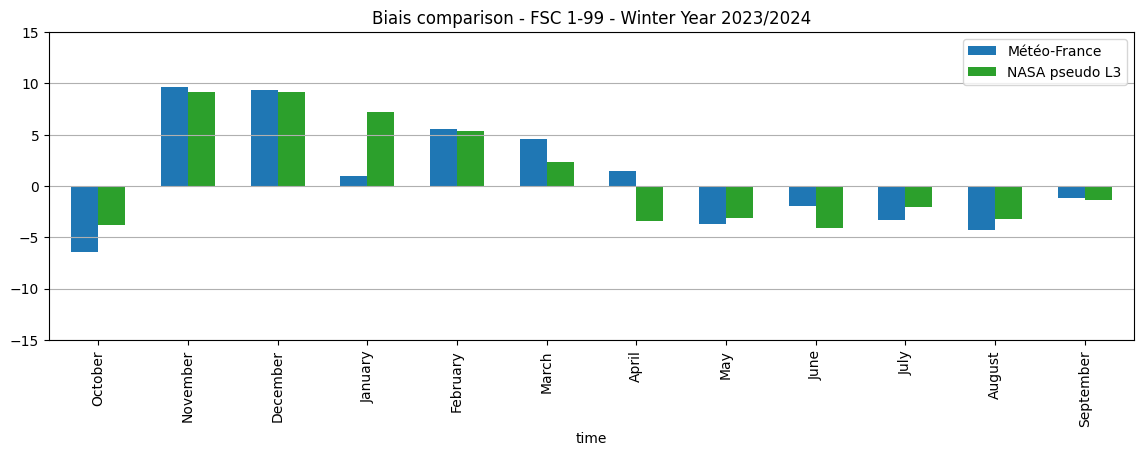

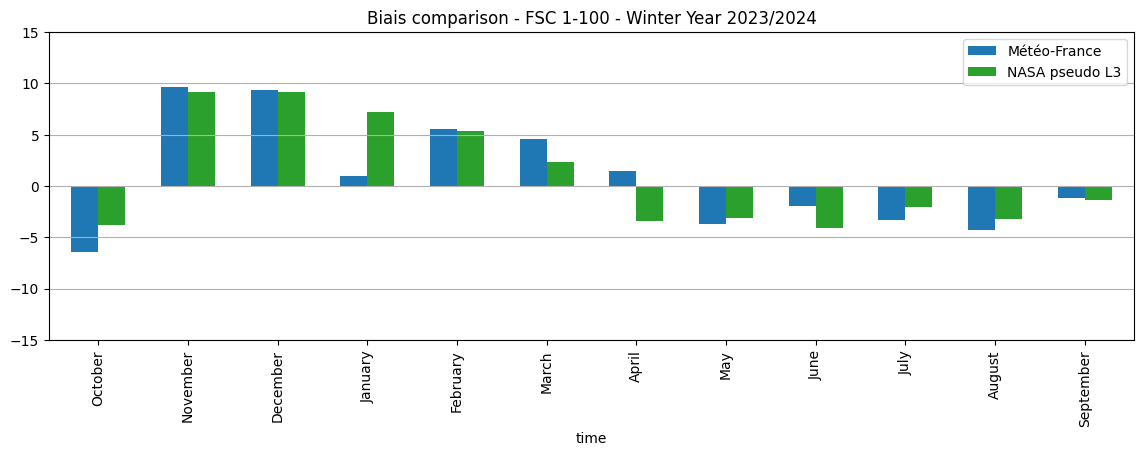

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_fsc = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_1000m_errors_fsc.nc')*100


for fsc_class in ['all','0', '1-99','1-100']:
    errors_fsc_class = errors_fsc.data_vars['biais'].sel(ref_fsc=fsc_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_fsc_class.sel(product='Météo-France').to_pandas(), 
                        #'NASA L3': errors_fsc_class.sel(product='NASA L3').to_pandas(),
                        'NASA pseudo L3': errors_fsc_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise'), width=0.6, title=f'Biais comparison - FSC {fsc_class} - Winter Year 2023/2024')
    plt.ylim([-15,15])
    plt.grid(True,axis='y')

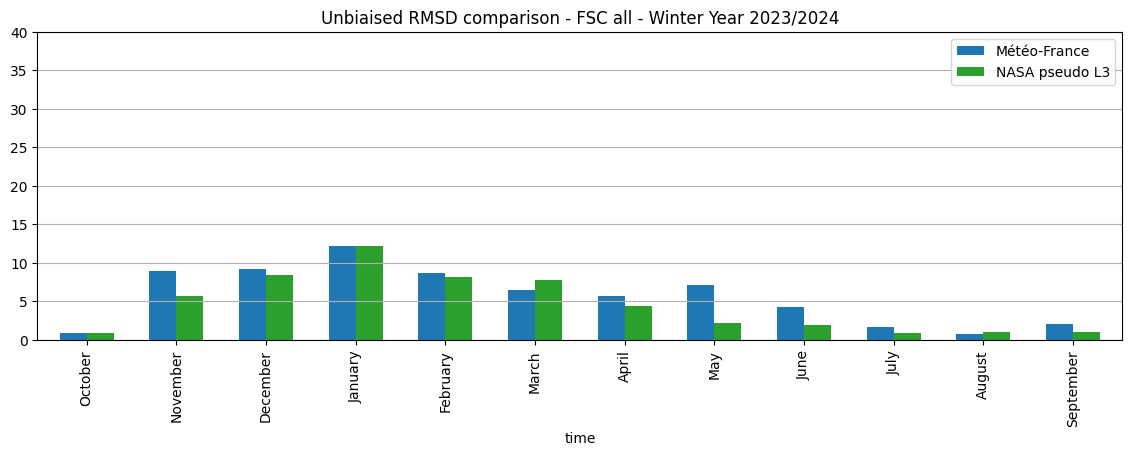

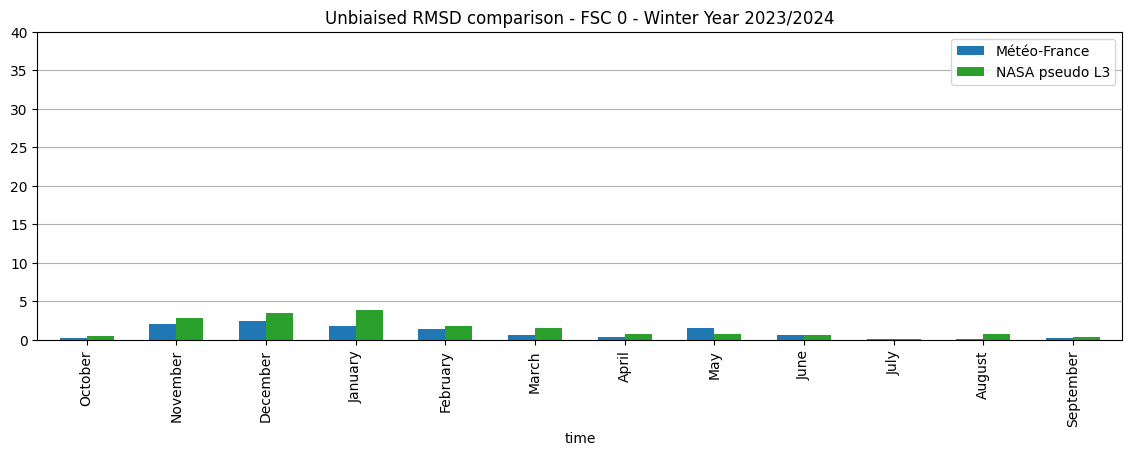

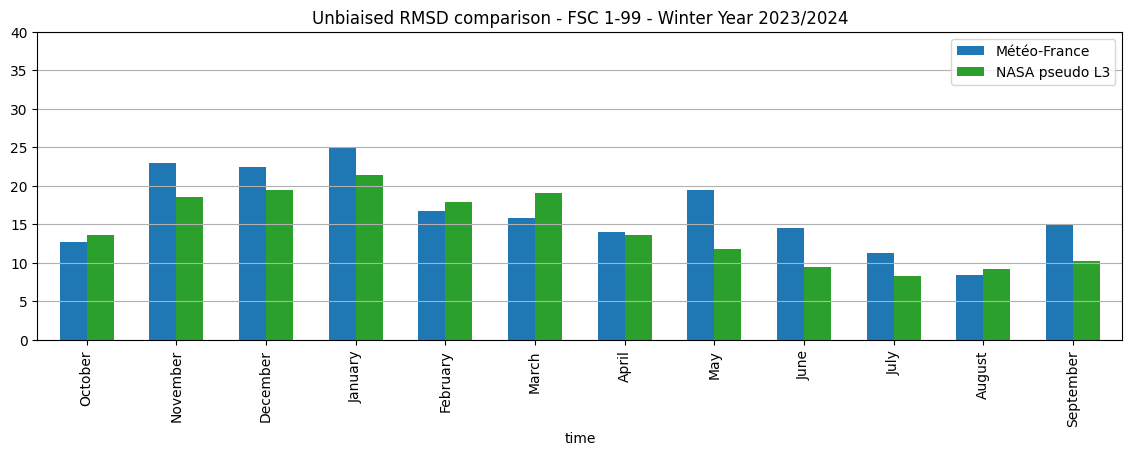

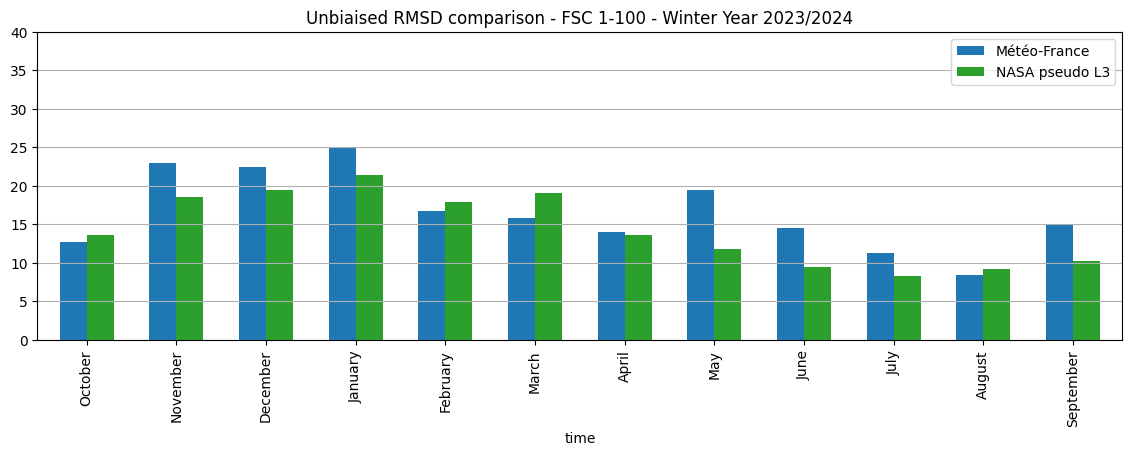

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_fsc = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_1000m_errors_fsc.nc')*100


for fsc_class in ['all','0', '1-99','1-100']:
    errors_fsc_class = errors_fsc.data_vars['unbiased_RMSD'].sel(ref_fsc=fsc_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_fsc_class.sel(product='Météo-France').to_pandas(), 
                        #'NASA L3': errors_fsc_class.sel(product='NASA L3').to_pandas(),
                        'NASA pseudo L3': errors_fsc_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise'), width=0.6, title=f'Unbiaised RMSD comparison - FSC {fsc_class} - Winter Year 2023/2024')
    plt.ylim([0,40])
    plt.grid(True,axis='y')

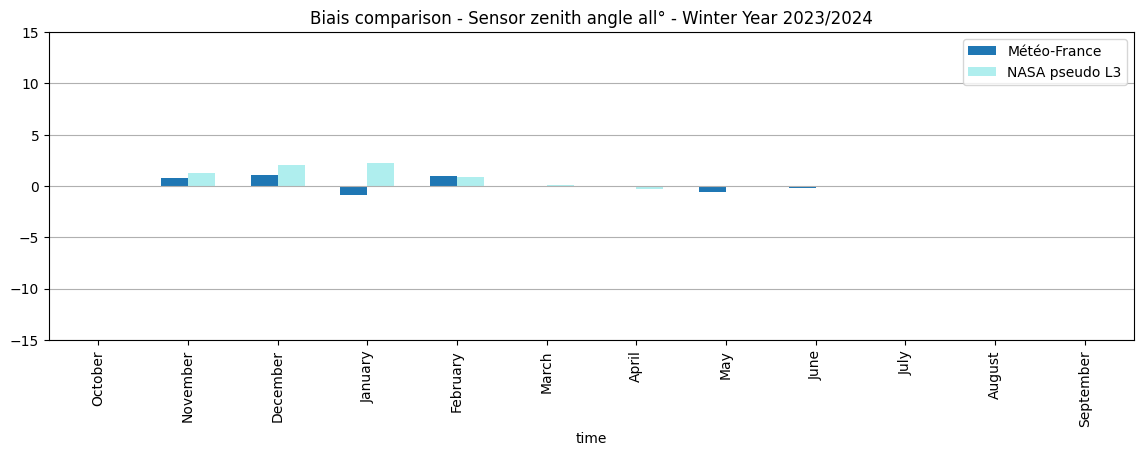

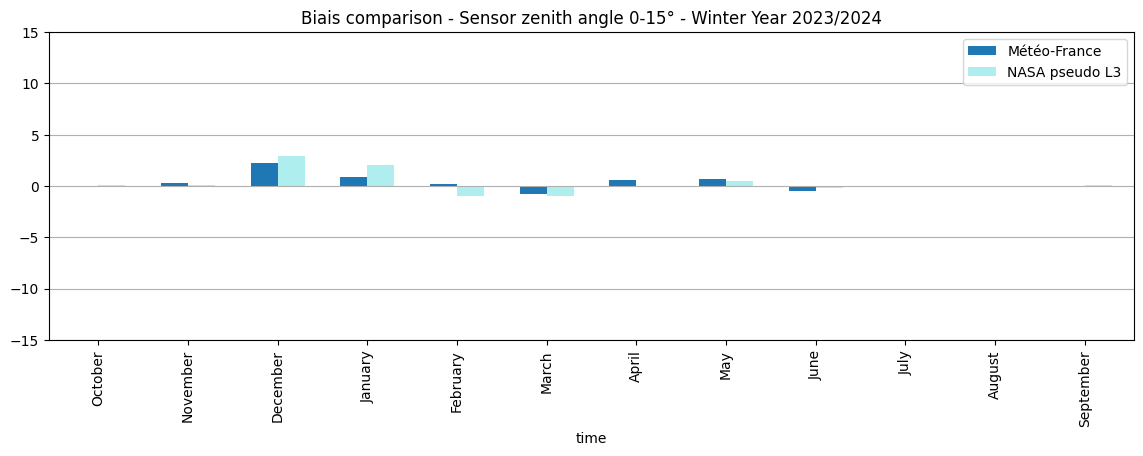

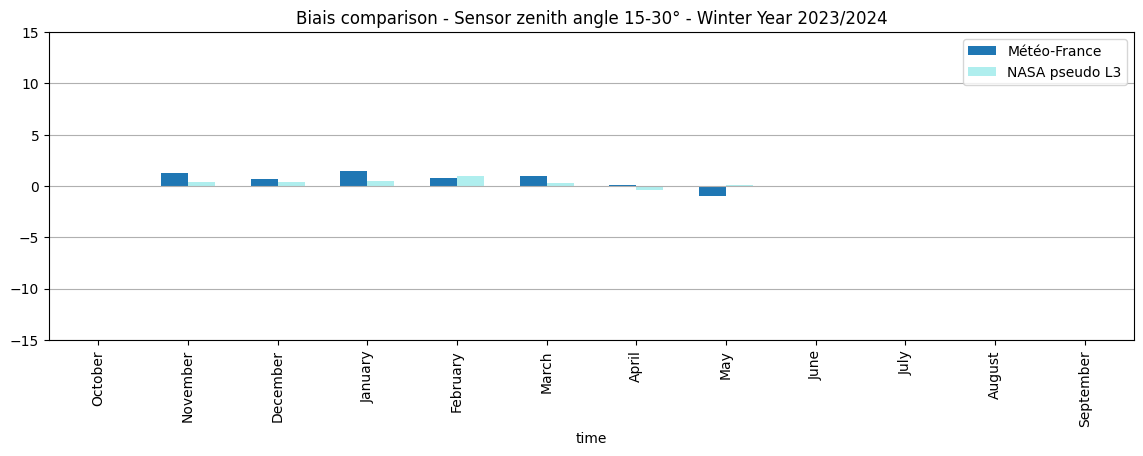

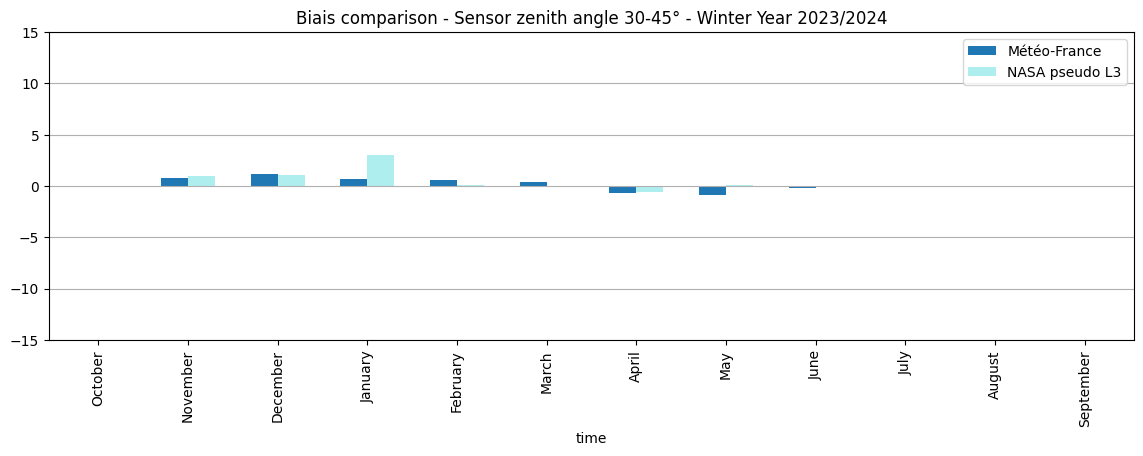

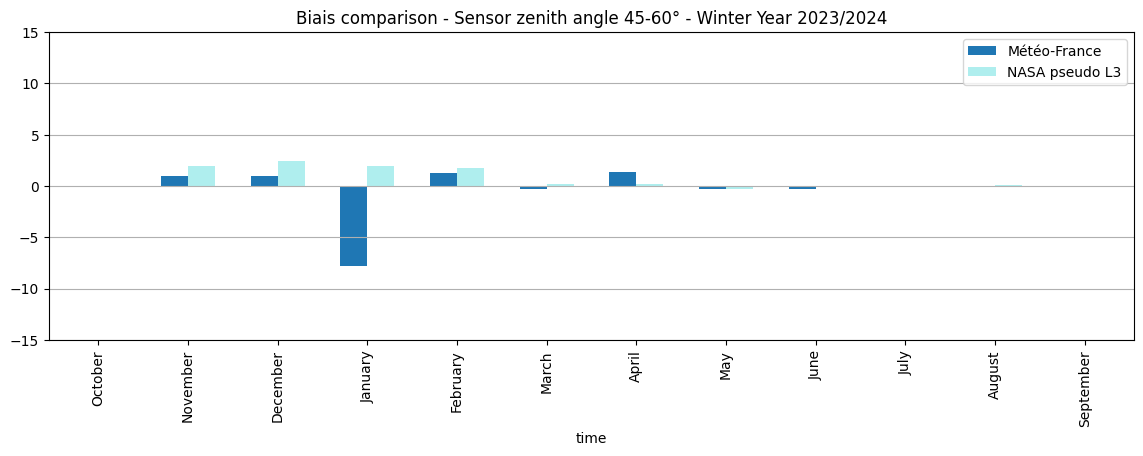

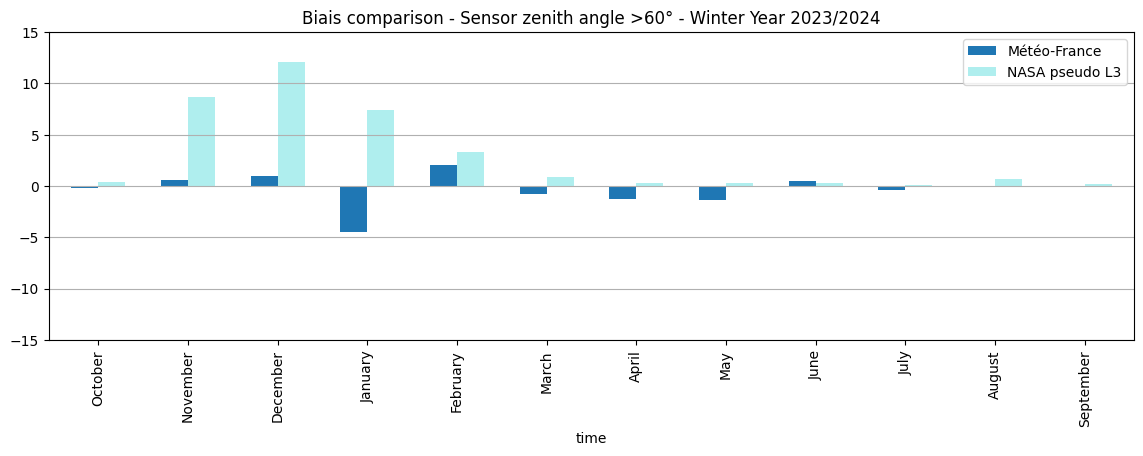

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_vza = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza.nc')*100


for sensor_class in ['all','0-15', '15-30','30-45','45-60','>60']:
    errors_vza_class = errors_vza.data_vars['biais'].sel(sensor_zenith=sensor_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_vza_class.sel(product='Météo-France').to_pandas(), 
                        'NASA pseudo L3': errors_vza_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue','paleturquoise'), width=0.6, title=f'Biais comparison - Sensor zenith angle {sensor_class}° - Winter Year 2023/2024')
    plt.ylim([-15,15])
    plt.grid(True,axis='y')

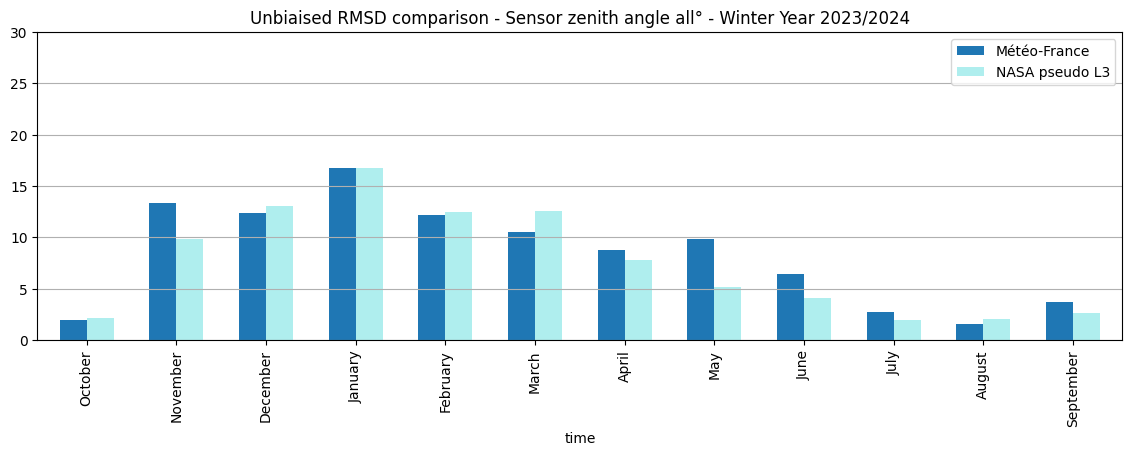

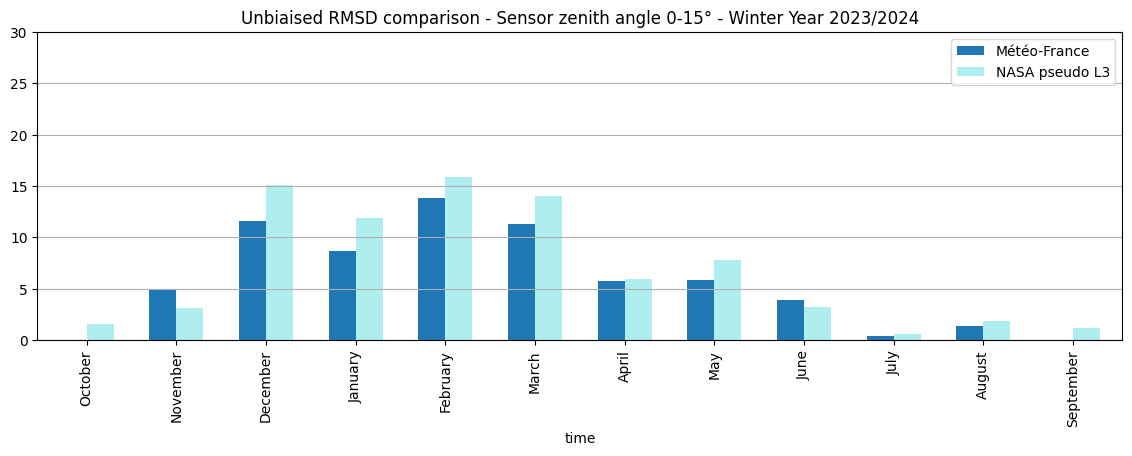

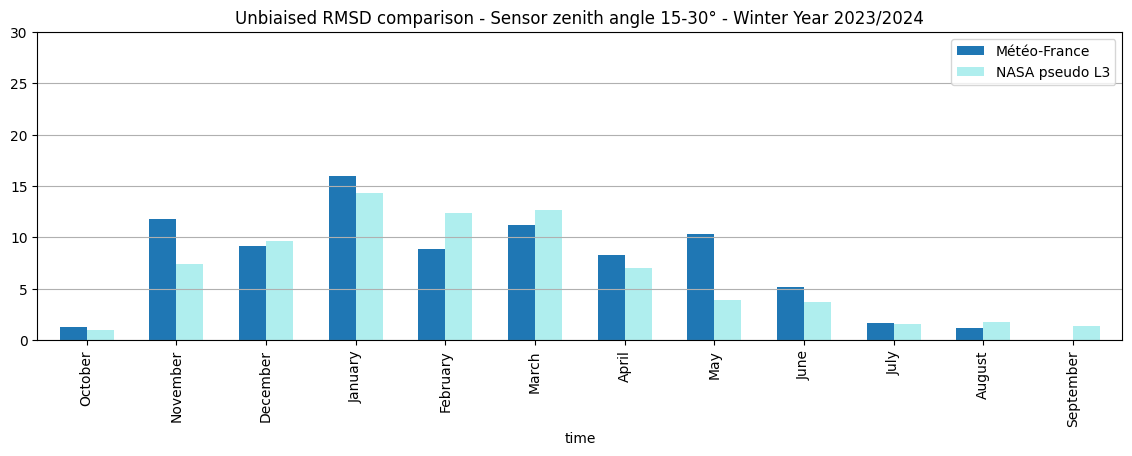

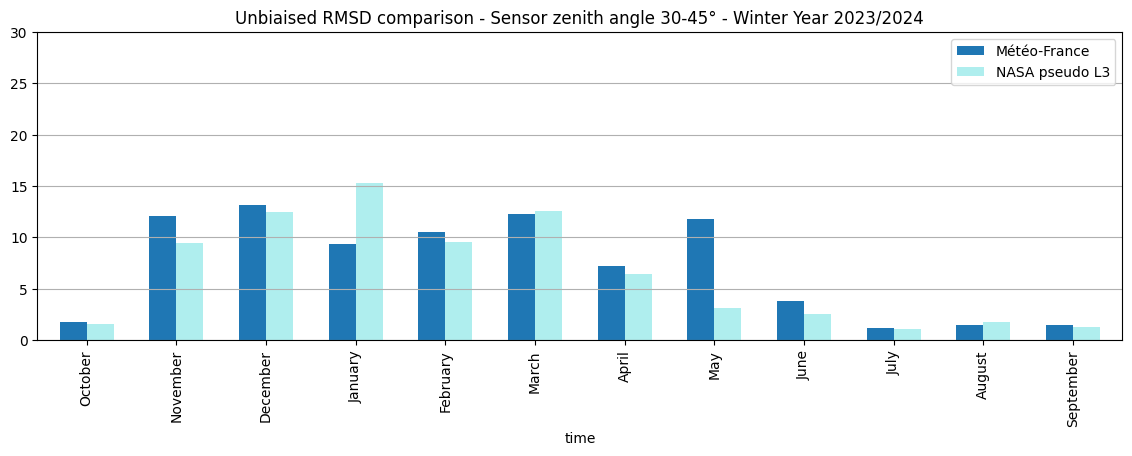

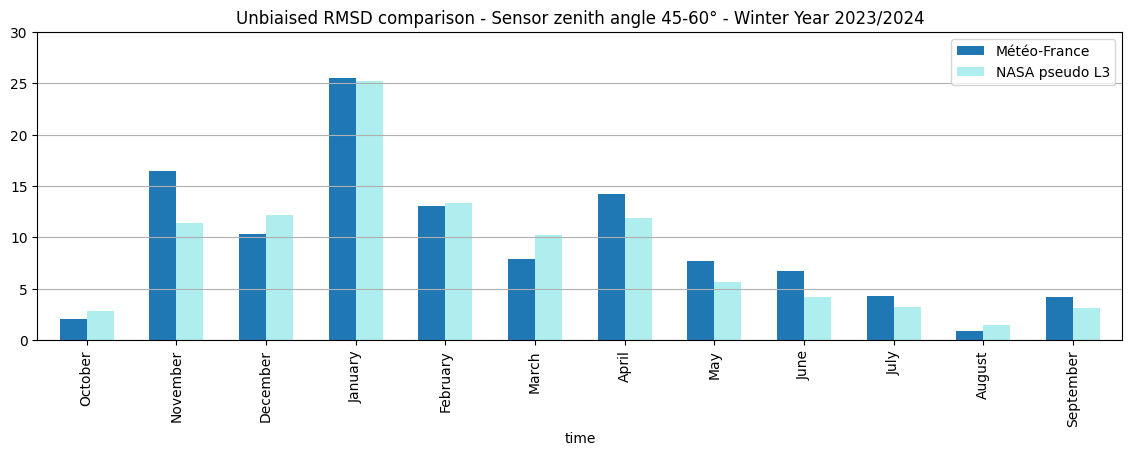

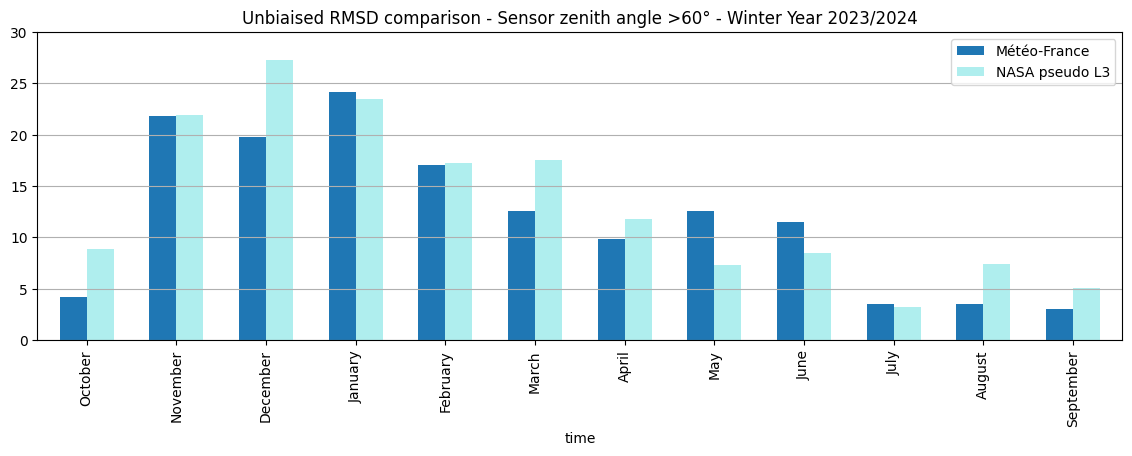

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_vza = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza.nc')*100


for sensor_class in ['all','0-15', '15-30','30-45','45-60','>60']:
    errors_vza_class = errors_vza.data_vars['unbiased_RMSD'].sel(sensor_zenith=sensor_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_vza_class.sel(product='Météo-France').to_pandas(), 
                        'NASA pseudo L3': errors_vza_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue','paleturquoise'), width=0.6, title=f'Unbiaised RMSD comparison - Sensor zenith angle {sensor_class}° - Winter Year 2023/2024')
    plt.ylim([0,30])
    plt.grid(True,axis='y')

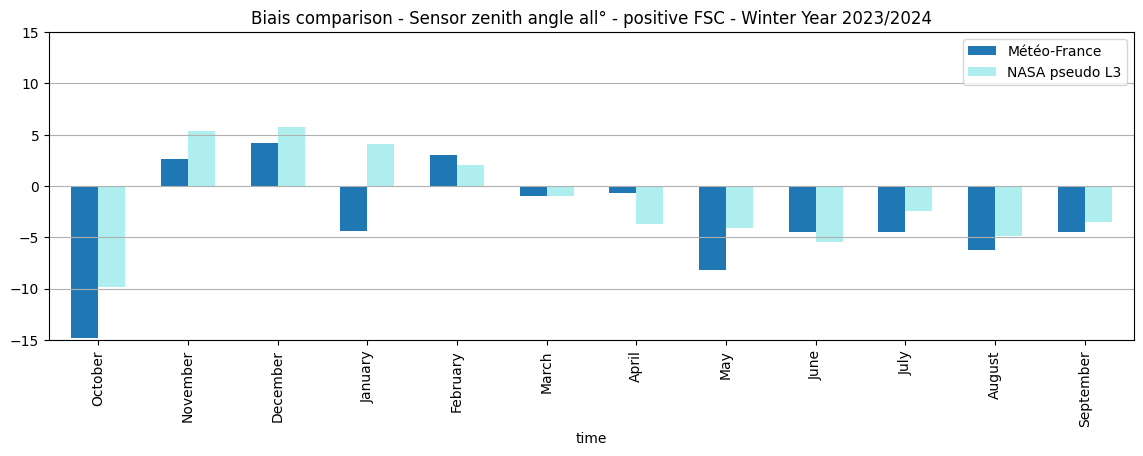

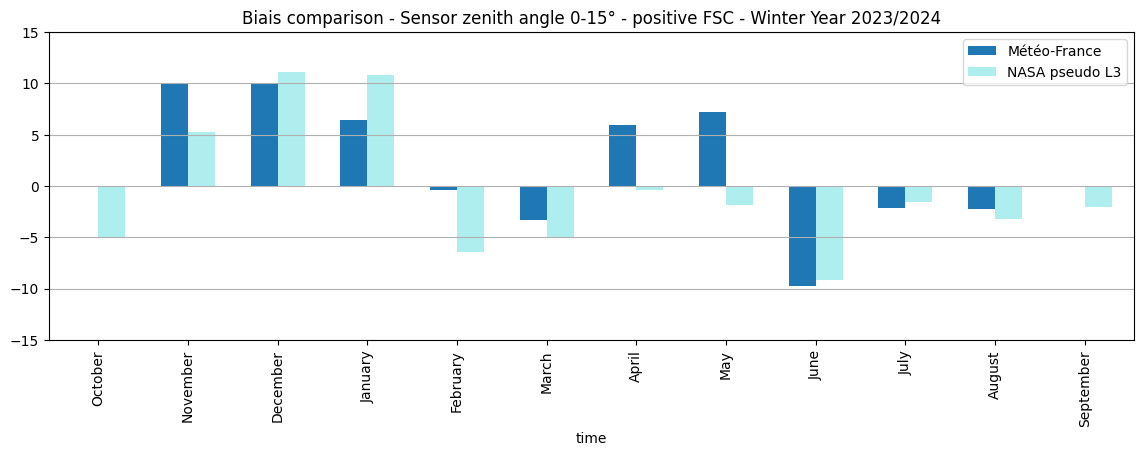

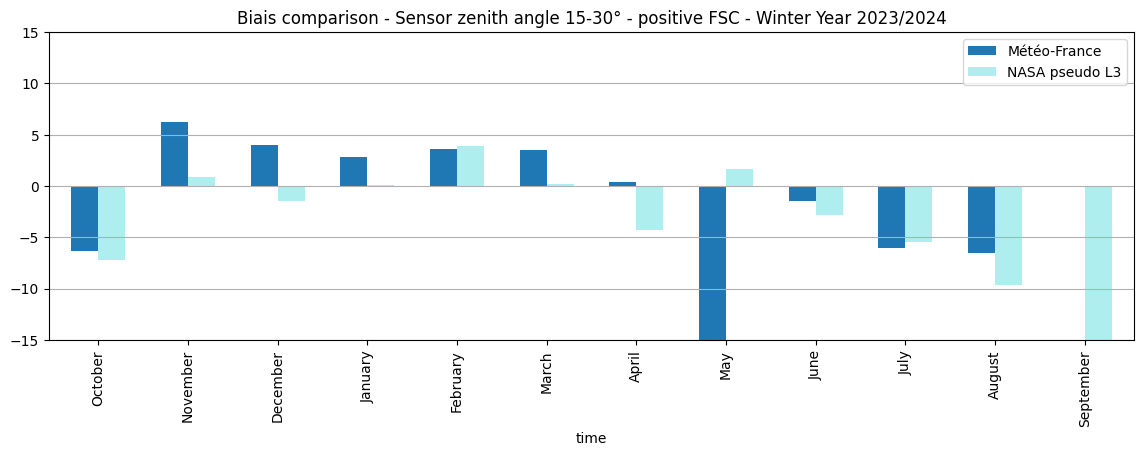

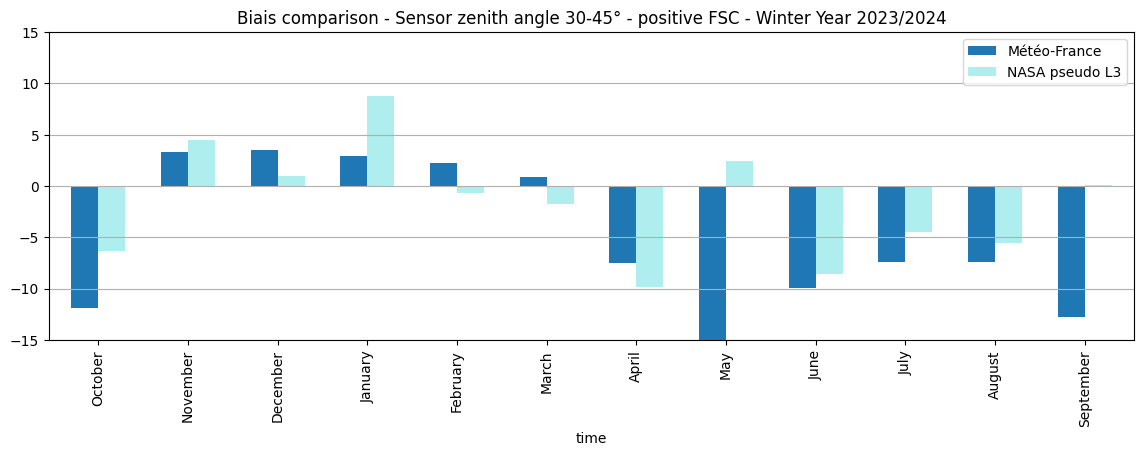

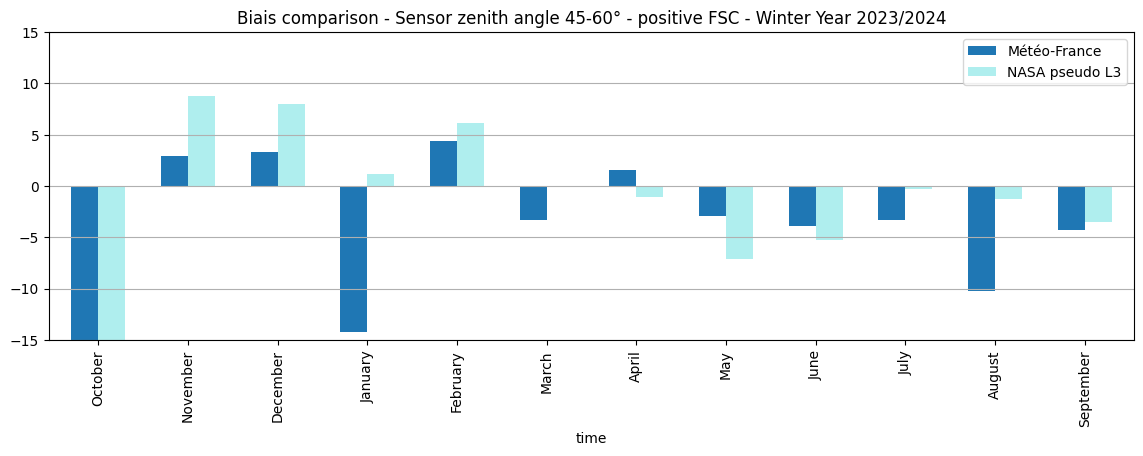

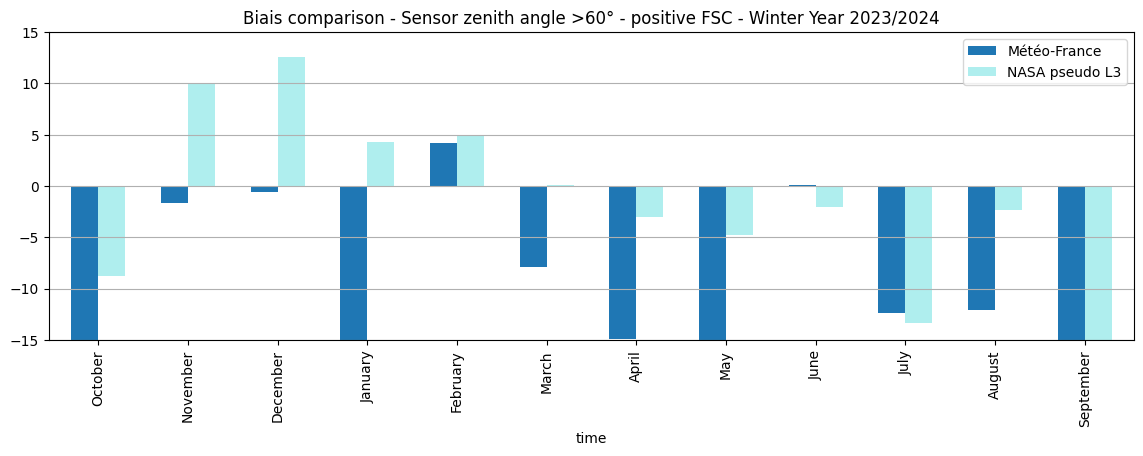

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_vza = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza_positive_fsc.nc')*100


for sensor_class in ['all','0-15', '15-30','30-45','45-60','>60']:
    errors_vza_class = errors_vza.data_vars['biais'].sel(sensor_zenith=sensor_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_vza_class.sel(product='Météo-France').to_pandas(), 
                        'NASA pseudo L3': errors_vza_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue','paleturquoise'), width=0.6, title=f'Biais comparison - Sensor zenith angle {sensor_class}° - positive FSC - Winter Year 2023/2024')
    plt.ylim([-15,15])
    plt.grid(True,axis='y')

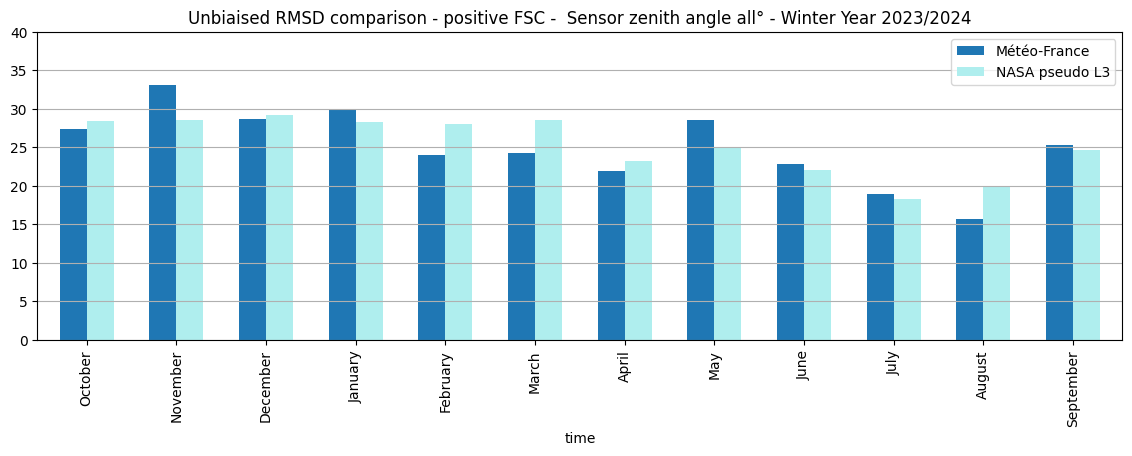

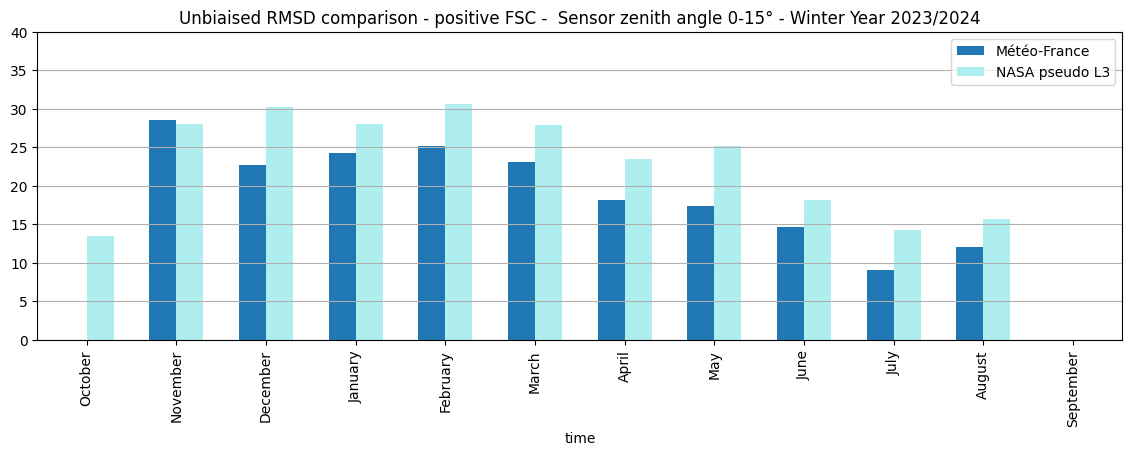

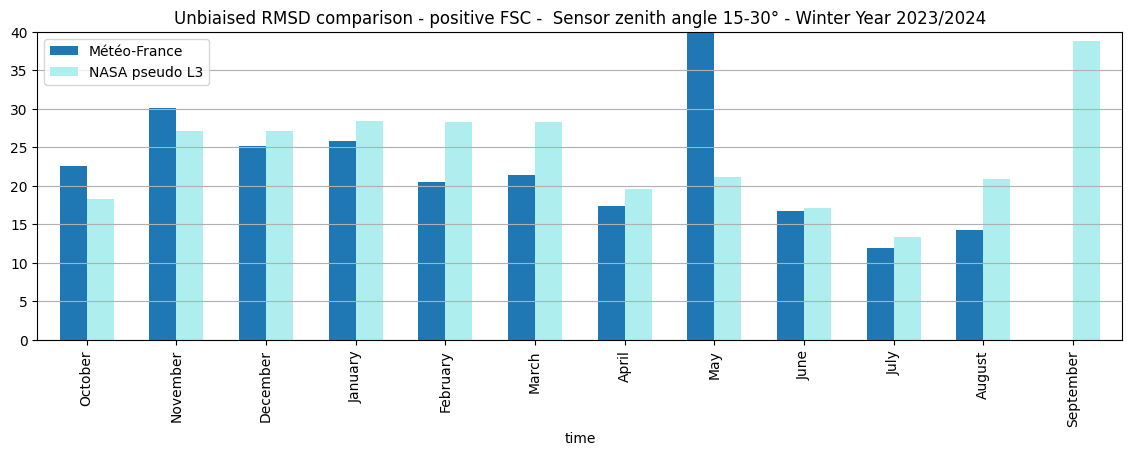

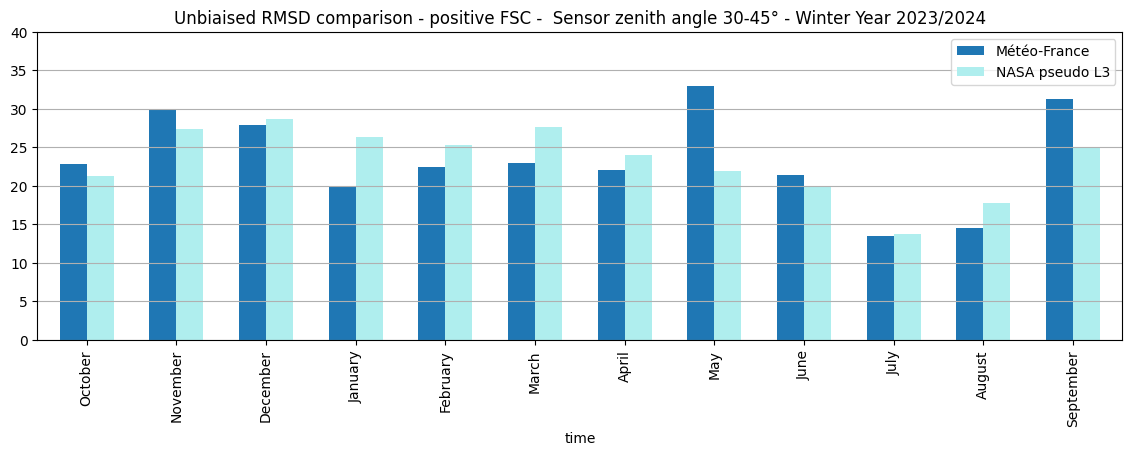

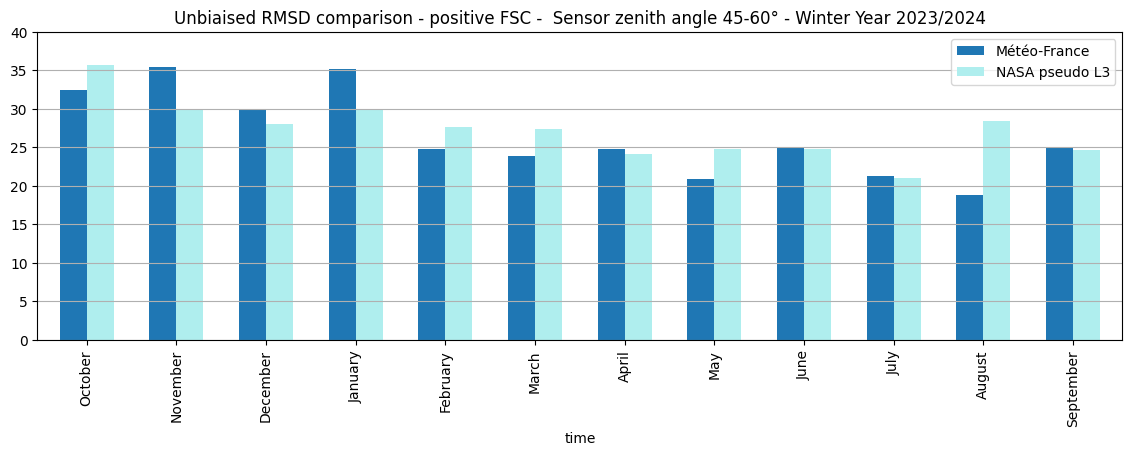

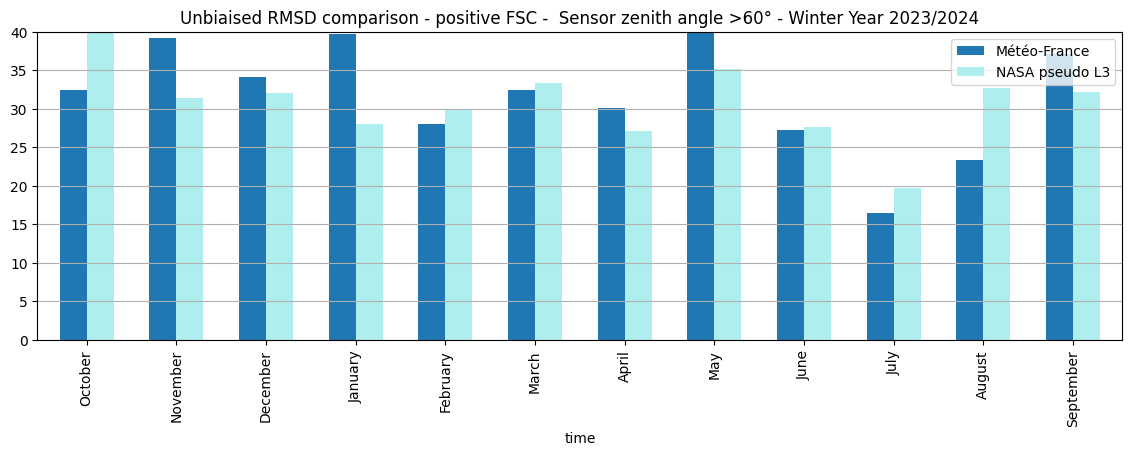

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_vza = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza_positive_fsc.nc')*100


for sensor_class in ['all','0-15', '15-30','30-45','45-60','>60']:
    errors_vza_class = errors_vza.data_vars['unbiased_RMSD'].sel(sensor_zenith=sensor_class).sortby('time')
    df = pd.DataFrame({'Météo-France': errors_vza_class.sel(product='Météo-France').to_pandas(), 
                        'NASA pseudo L3': errors_vza_class.sel(product='NASA pseudo L3').to_pandas()
                    })

    df.index = df.index.strftime("%B")
    df.plot.bar(figsize=(14,4), color=('tab:blue','paleturquoise'), width=0.6, title=f'Unbiaised RMSD comparison - positive FSC -  Sensor zenith angle {sensor_class}° - Winter Year 2023/2024')
    plt.ylim([0,40])
    plt.grid(True,axis='y')

In [9]:
xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza.nc')

<xarray.Dataset> Size: 3kB
Dimensions:        (time: 12, product: 2, sensor_zenith: 6)
Coordinates:
  * time           (time) datetime64[ns] 96B 2023-10-01 ... 2024-09-01
  * product        (product) <U14 112B 'Météo-France' 'NASA pseudo L3'
  * sensor_zenith  (sensor_zenith) <U5 120B '0-15' '15-30' ... '>60' 'all'
Data variables:
    biais          (time, product, sensor_zenith) float64 1kB ...
    unbiased_RMSD  (time, product, sensor_zenith) float64 1kB ...

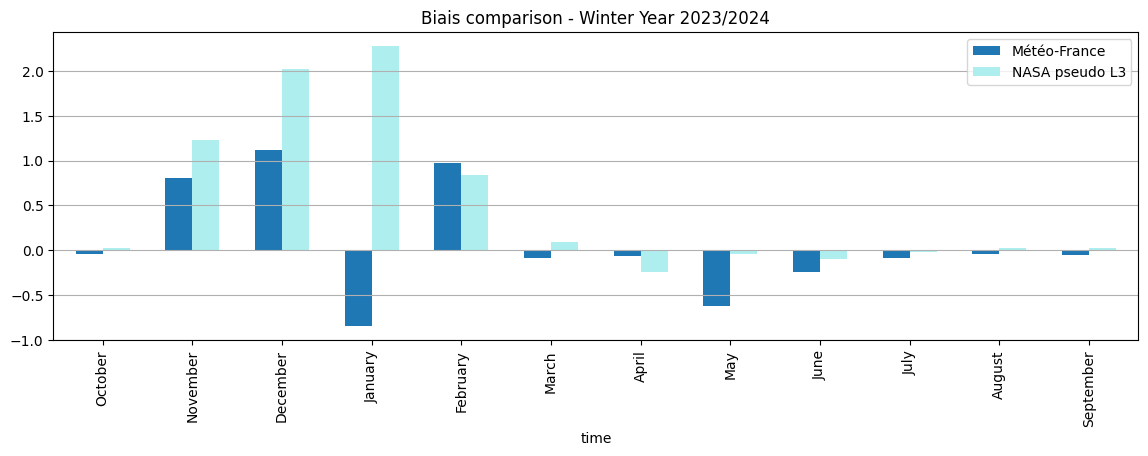

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

errors_fsc = xr.open_dataset(f'{time_series_folder}/WY_2023_2024_SNPP_res_375m_errors_vza.nc')*100
errors_fsc = errors_fsc.data_vars['biais'].sel(sensor_zenith='all').sortby('time')

df = pd.DataFrame({'Météo-France': errors_fsc.sel(product='Météo-France').to_pandas(), 
                    'NASA pseudo L3': errors_fsc.sel(product='NASA pseudo L3').to_pandas()
                })

df.index = df.index.strftime("%B")
df.plot.bar(figsize=(14,4), color=('tab:blue', 'paleturquoise'), width=0.6, title='Biais comparison - Winter Year 2023/2024')
plt.grid(True,axis='y')

In [3]:
from typing import Dict

from products.classes import METEOFRANCE_CLASSES, NASA_CLASSES, S2_CLASSES


valid_ranges_dict = {'Sentinel-2': {'fsc_max': S2_CLASSES['snow_cover'][-1]},
                     'Météo-France': {'fsc_max': METEOFRANCE_CLASSES['snow_cover'][-1]},
                     'NASA L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]},
                     'NASA pseudo L3': {'fsc_max': NASA_CLASSES['snow_cover'][-1]}}

def compute_daily_bias_rmse_landcover(ref_time_series: Dict[str, xr.Dataset], time_series_to_compare: Dict[str, xr.Dataset], fsc_threshold: float = 0, forest_mask: xr.DataArray | None = None):

    time_coordinate = find_common_days(time_series_list=list(ref_time_series).extend(list(time_series_to_compare.values())))
    errors = xr.Dataset({'bias': xr.DataArray(np.nan, coords={'time':time_coordinate, 'product': time_series_to_compare.keys(), 'landcover': ['no_forest', 'forest', 'all']}),
                    'unbiased_RMSD': xr.DataArray(np.nan, coords={'time':time_coordinate, 'product': time_series_to_compare.keys(),'landcover': ['no_forest', 'forest', 'all']})})

    for day in time_coordinate:
        ref_snow_cover = ref_time_series.data_vars['snow_cover_fraction'].sel(time=day)
        ref_mask = ref_snow_cover  < valid_ranges_dict[ref_time_series.keys()[0]]['fsc_max'] & ref_snow_cover  >= fsc_threshold*valid_ranges_dict[ref_time_series.keys()[0]]['fsc max']
        ref_snow_cover = ref_snow_cover.where(ref_mask)
        for product_name, product in time_series_to_compare:
            product_snow_cover = product.data_vars['snow_cover_fraction'].sel(time=day)
            product_mask = product_snow_cover  < valid_ranges_dict[product_name]['fsc_max'] & ref_snow_cover  >= fsc_threshold*valid_ranges_dict[product_name]['fsc_max']
            product_snow_cover = product.where(product_mask)
            difference = product_snow_cover - ref_snow_cover
            biais, rmse = difference_array_to_bias_rmse(difference)
            errors.data_vars['biais']['all'] = biais
            errors.data_vars['unbiased_RMSD']['all'] = rmse
            if forest_mask is not None:
                difference = product_snow_cover.where(forest_mask) - ref_snow_cover.where(forest_mask)
                biais, rmse = difference_array_to_bias_rmse(difference)
                errors.data_vars['biais']['forest'] = biais
                errors.data_vars['unbiased_RMSD']['forest'] = rmse
                difference = product_snow_cover.where(~forest_mask) - ref_snow_cover.where(~forest_mask)
                biais, rmse = difference_array_to_bias_rmse(difference)
                errors.data_vars['biais']['no_forest'] = biais
                errors.data_vars['unbiased_RMSD']['no_forest'] = rmse

    errors.to_netcdf(f'{time_series_folder}/WY_2023_2024_SNPP_errors_landcover.nc')

/tmp/ipykernel_7457/3997056545.py:12: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_7457/3997056545.py:14: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_7457/3997056545.py:12: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_7457/3997056545.py:14: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_7457/3997056545.py:12: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_7457/3997056545.py:14: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_7457/3997056545.py:12: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_7457/3997056545.py:14: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_7457/3997056545.py:12: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_7457

In [8]:
biases, rmses = [],[]
for day in common_days:
    mf_snow_forest_mask = meteofrance_time_series.data_vars['snow_cover'].sel(time=day) != 210
    nasa = nasa_time_series.data_vars['snow_cover'].sel(time=day) /100
    nasa_mask = nasa <=1
    s2 = s2_time_series.data_vars['snow_cover'].sel(time=day) / 100
    s2_mask = s2<=1
    nasa = nasa.where(nasa_mask).where(mf_snow_forest_mask)
    s2 =  s2.where(s2_mask)
    nasa = nasa.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    s2 = s2.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    diff = nasa - s2
    b = np.nanmean(diff)
    biases.append(b)
    rmses.append(np.sqrt(np.nanmean((diff- b)**2)))

errors_nasa_no_forest = xr.Dataset({'bias': xr.DataArray(biases, coords={'time':common_days}),
                    'rmse': xr.DataArray(rmses, coords={'time':common_days})})
errors_nasa_no_forest.to_netcdf('errors_nasa_no_forest_1km.nc')

/tmp/ipykernel_14573/4160990851.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/4160990851.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/4160990851.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/4160990851.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/4160990851.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/4160990851.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/4160990851.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/4160990851.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/4160990851.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipyke

In [7]:


biases, rmses = [],[]
for day in common_days:
    mf_snow_forest_mask = meteofrance_time_series.data_vars['snow_cover'].sel(time=day) == 210
    nasa = nasa_time_series.data_vars['snow_cover'].sel(time=day) /100
    nasa_mask = nasa <=1
    s2 = s2_time_series.data_vars['snow_cover'].sel(time=day) / 100
    s2_mask = s2<=1
    nasa = nasa.where(nasa_mask).where(mf_snow_forest_mask) 
    s2 = s2.where(s2_mask)
    nasa = nasa.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    s2 = s2.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    diff = nasa- s2
    b = np.nanmean(diff)
    biases.append(b)
    rmses.append(np.sqrt(np.nanmean((diff- b)**2)))

errors_nasa_forest = xr.Dataset({'bias': xr.DataArray(biases, coords={'time':common_days}),
                    'rmse': xr.DataArray(rmses, coords={'time':common_days})})
errors_nasa_forest.to_netcdf('errors_nasa_forest_1km.nc')

/tmp/ipykernel_14573/2832533926.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/2832533926.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/2832533926.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/2832533926.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/2832533926.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/2832533926.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/2832533926.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/2832533926.py:15: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/2832533926.py:13: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipyke

In [4]:

biases, rmses = [],[]
for day in common_days:
    mf = meteofrance_time_series.data_vars['snow_cover'].sel(time=day) /200
    mf_mask = mf <=1
    s2 = s2_time_series.data_vars['snow_cover'].sel(time=day) / 100
    s2_mask = s2<=1
    mf = mf.where(mf_mask) 
    s2 = s2.where(s2_mask)

    mf = mf.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    s2 = s2.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
    
    diff = mf - s2
    b = np.nanmean(diff)

    biases.append(b)
    rmses.append(np.sqrt(np.nanmean((diff- b)**2)))

errors_mf = xr.Dataset({'bias': xr.DataArray(biases, coords={'time':common_days}),
                    'rmse': xr.DataArray(rmses, coords={'time':common_days})})
errors_mf.to_netcdf('errors_meteofrance_1km.nc')

/tmp/ipykernel_14573/382037027.py:14: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/382037027.py:17: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/382037027.py:14: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/382037027.py:17: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/382037027.py:14: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/382037027.py:17: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/382037027.py:14: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_14573/382037027.py:17: RuntimeWarning: Mean of empty slice
  rmses.append(np.sqrt(np.nanmean((diff- b)**2)))
/tmp/ipykernel_14573/382037027.py:14: RuntimeWarning: Mean of empty slice
  b = np.nanmean(diff)
/tmp/ipykernel_1457

Comparison data resampled at 1 km cell size

In [4]:
errors_nasa = xr.open_dataset('errors_nasa_1km.nc')
errors_nasa_no_forest = xr.open_dataset('errors_nasa_no_forest_1km.nc')
errors_nasa_forest = xr.open_dataset('errors_nasa_forest_1km.nc')
errors_mf = xr.open_dataset('errors_meteofrance_1km.nc')

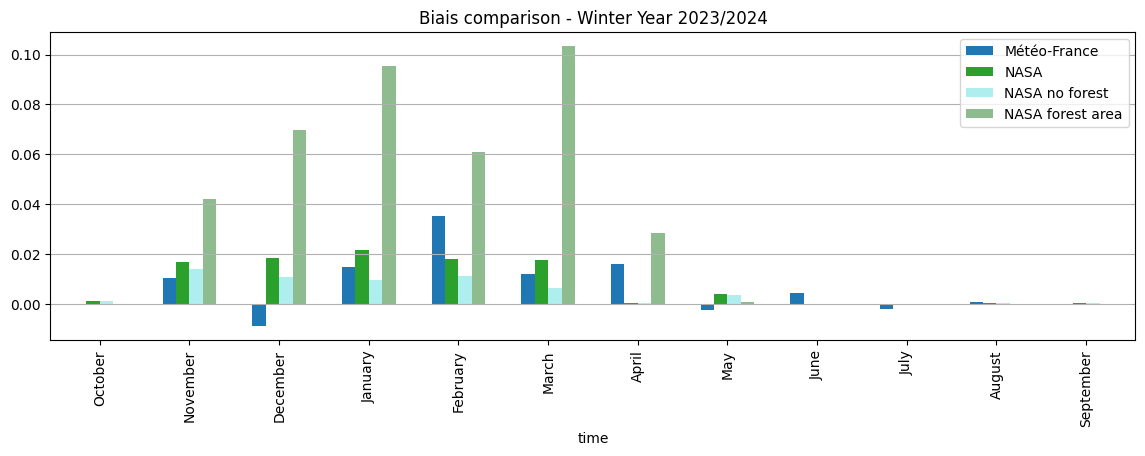

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
nasa_series = errors_nasa.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_no_forest_series = errors_nasa_no_forest.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
meteofrance_series = errors_mf.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_forest_series = errors_nasa_forest.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()

rmse_df = pd.DataFrame({ 'Météo-France': meteofrance_series, 'NASA': nasa_series,'NASA no forest': nasa_no_forest_series,'NASA forest area': nasa_forest_series})
rmse_df.index = rmse_df.index.strftime("%B")
rmse_df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise', 'darkseagreen'), width=0.6, title='Biais comparison - Winter Year 2023/2024')
plt.grid(True,axis='y')

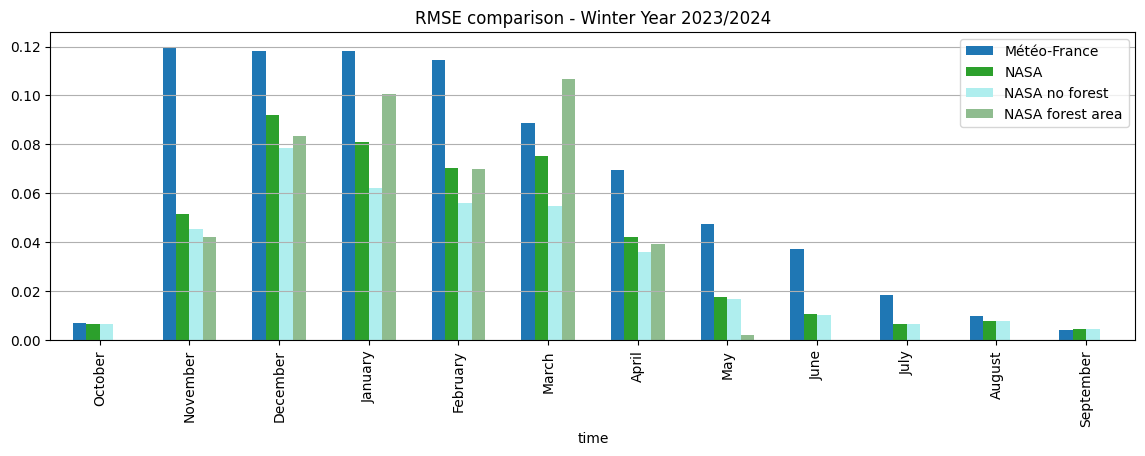

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
nasa_series = errors_nasa.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_no_forest_series = errors_nasa_no_forest.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
meteofrance_series = errors_mf.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_forest_series = errors_nasa_forest.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()

rmse_df = pd.DataFrame({ 'Météo-France': meteofrance_series, 'NASA': nasa_series,'NASA no forest': nasa_no_forest_series,'NASA forest area': nasa_forest_series})
rmse_df.index = rmse_df.index.strftime("%B")
rmse_df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise', 'darkseagreen'), width=0.6, title='RMSE comparison - Winter Year 2023/2024')
plt.grid(True,axis='y')

Comparison data at 250 m resolution

In [115]:
errors_nasa = xr.open_dataset('errors_nasa.nc')
errors_nasa_no_forest = xr.open_dataset('errors_nasa_no_forest.nc')
errors_nasa_forest = xr.open_dataset('errors_nasa_forest.nc')
errors_mf = xr.open_dataset('errors_meteofrance.nc')

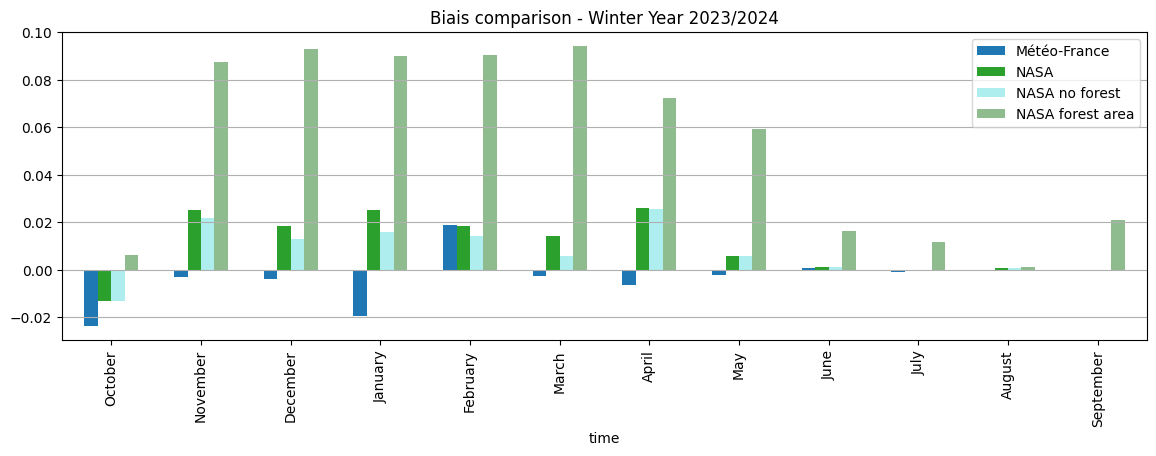

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
nasa_series = errors_nasa.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_no_forest_series = errors_nasa_no_forest.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
meteofrance_series = errors_mf.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_forest_series = errors_nasa_forest.data_vars['bias'].groupby('time.month').map(daily_average).sortby('time').to_pandas()

rmse_df = pd.DataFrame({ 'Météo-France': meteofrance_series, 'NASA': nasa_series,'NASA no forest': nasa_no_forest_series,'NASA forest area': nasa_forest_series})
rmse_df.index = rmse_df.index.strftime("%B")
rmse_df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise', 'darkseagreen'), width=0.6, title='Biais comparison - Winter Year 2023/2024')
plt.grid(True,axis='y')

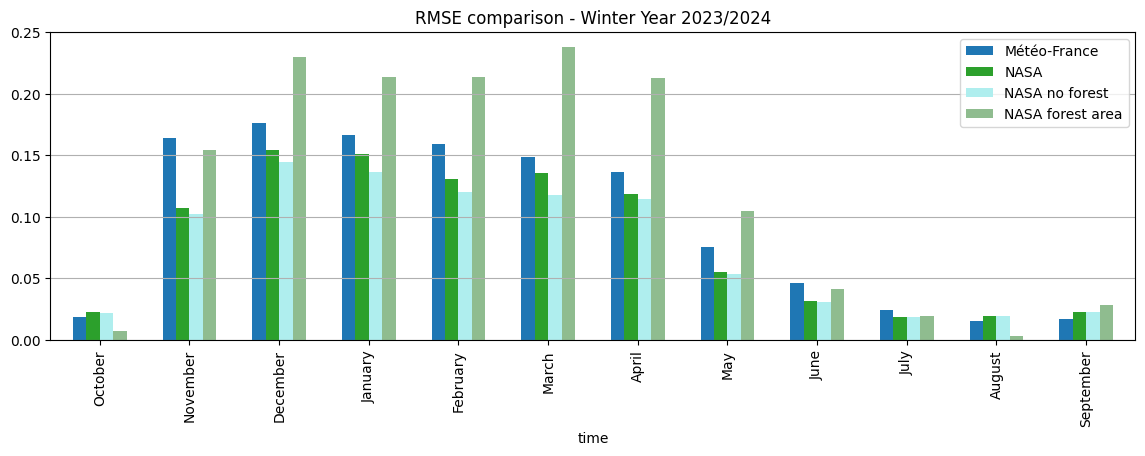

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
nasa_series = errors_nasa.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_no_forest_series = errors_nasa_no_forest.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
meteofrance_series = errors_mf.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_forest_series = errors_nasa_forest.data_vars['rmse'].groupby('time.month').map(daily_average).sortby('time').to_pandas()

rmse_df = pd.DataFrame({ 'Météo-France': meteofrance_series, 'NASA': nasa_series,'NASA no forest': nasa_no_forest_series,'NASA forest area': nasa_forest_series})
rmse_df.index = rmse_df.index.strftime("%B")
rmse_df.plot.bar(figsize=(14,4), color=('tab:blue', 'tab:green','paleturquoise', 'darkseagreen'), width=0.6, title='RMSE comparison - Winter Year 2023/2024')
plt.grid(True,axis='y')